⚠ Warning: togo data missing: GHI, DNI, DHI. Proceeding with available data.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22056\3025908356.py:59: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=data, ax=axes[i], width=0.6,


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

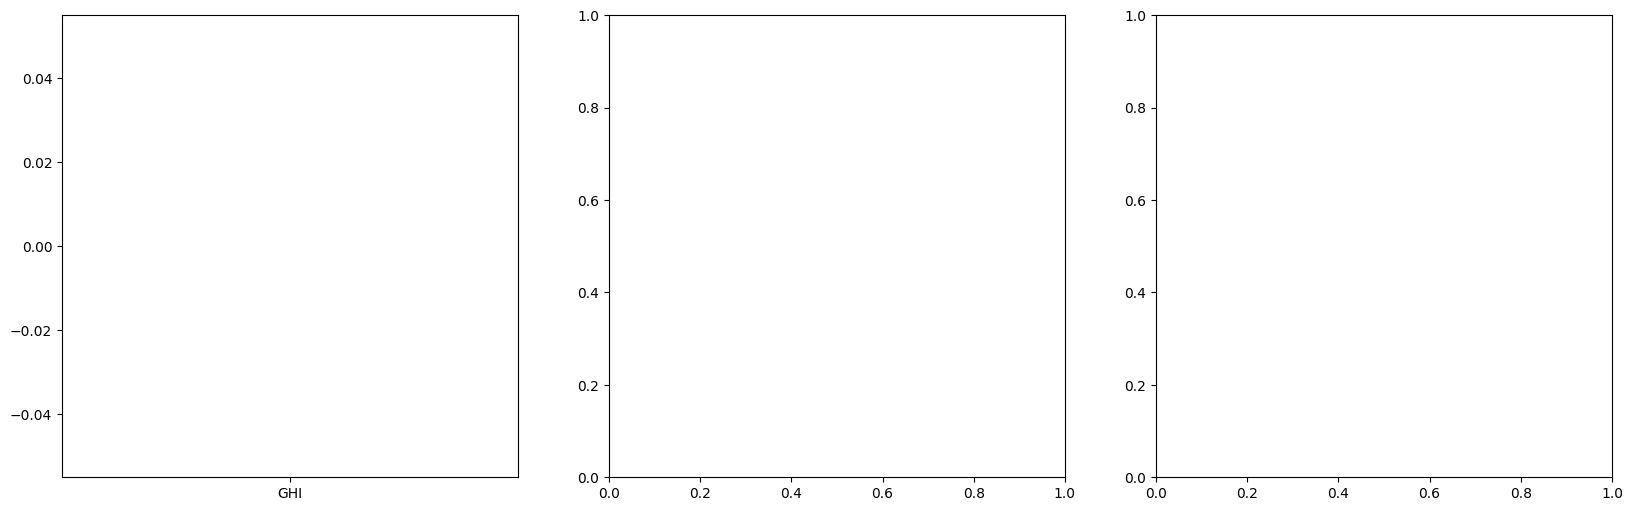

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import os

# ======================
# 1. DATA LOADING & VALIDATION
# ======================

def load_and_validate(country):
    """Load cleaned data with validation"""
    filepath = f"data/{country}_clean.csv"

    # Verify file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Clean data not found for {country}. Run Task 2 cleaning first.")

    df = pd.read_csv(filepath)

    # Standardize column names
    df.columns = df.columns.str.strip().str.upper()

    # Required solar metrics
    required_metrics = ['GHI', 'DNI', 'DHI']

    # Check for missing columns
    missing = [m for m in required_metrics if m not in df.columns]
    if missing:
        print(f"⚠ Warning: {country} data missing: {', '.join(missing)}. Proceeding with available data.")
        for metric in missing:
            df[metric] = np.nan  # Add missing columns with NaN values

    return df

# Load all country data
try:
    benin = load_and_validate('benin')
    sierra = load_and_validate('sierra_leone')
    togo = load_and_validate('togo')
except Exception as e:
    print(f"Data loading failed: {str(e)}")
    raise

# ======================
# 2. METRIC COMPARISON
# ======================

def plot_metric_comparison():
    """Generate side-by-side comparison plots"""
    metrics = ['GHI', 'DNI', 'DHI']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, metric in enumerate(metrics):
        data = [benin[metric], sierra[metric], togo[metric]]
        
        # Boxplot
        sns.boxplot(data=data, ax=axes[i], width=0.6, 
                   palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
        axes[i].set_xticklabels(['Benin', 'Sierra Leone', 'Togo'])
        axes[i].set_title(f'{metric} Distribution', fontsize=14)
        axes[i].set_ylabel('Irradiance (W/m²)', fontsize=12)
        
        # Add mean markers
        for j, country_data in enumerate(data):
            axes[i].scatter(j, country_data.mean(), color='red', zorder=10, label='Mean')
        
        if i == 0:
            axes[i].legend()
    
    plt.suptitle('Solar Radiation Metrics Comparison', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_metric_comparison()

# ======================
# 3. STATISTICAL SUMMARY
# ======================

# Create comprehensive summary
summary = pd.concat([
    benin[['GHI', 'DNI', 'DHI']].describe().loc[['mean', '50%', 'std']].rename(columns=lambda x: f'BENIN_{x}'),
    sierra[['GHI', 'DNI', 'DHI']].describe().loc[['mean', '50%', 'std']].rename(columns=lambda x: f'SIERRA_{x}'),
    togo[['GHI', 'DNI', 'DHI']].describe().loc[['mean', '50%', 'std']].rename(columns=lambda x: f'TOGO_{x}')
], axis=1)

print("Statistical Summary:")
display(summary.style.background_gradient(cmap='Blues', axis=1))

# ======================
# 4. HYPOTHESIS TESTING
# ======================

print("\nStatistical Significance Testing:")

for metric in ['GHI', 'DNI', 'DHI']:
    print(f"\n--- {metric} ---")
    
    # Parametric ANOVA
    anova = f_oneway(benin[metric], sierra[metric], togo[metric])
    print(f"ANOVA p-value: {anova.pvalue:.4f} ({'significant' if anova.pvalue < 0.05 else 'not significant'})")
    
    # Non-parametric Kruskal-Wallis
    kw = kruskal(benin[metric], sierra[metric], togo[metric])
    print(f"Kruskal-Wallis p-value: {kw.pvalue:.4f}")

# ======================
# 5. COUNTRY RANKING
# ======================

# Calculate country scores (weighted average)
weights = {'GHI': 0.5, 'DNI': 0.3, 'DHI': 0.2}
country_scores = pd.DataFrame({
    'Country': ['Benin', 'Sierra Leone', 'Togo'],
    'Score': [
        (benin['GHI'].mean()*weights['GHI'] + benin['DNI'].mean()*weights['DNI'] + benin['DHI'].mean()*weights['DHI']),
        (sierra['GHI'].mean()*weights['GHI'] + sierra['DNI'].mean()*weights['DNI'] + sierra['DHI'].mean()*weights['DHI']),
        (togo['GHI'].mean()*weights['GHI'] + togo['DNI'].mean()*weights['DNI'] + togo['DHI'].mean()*weights['DHI'])
    ]
}).sort_values('Score', ascending=False)

# Visual ranking
plt.figure(figsize=(10, 6))
sns.barplot(data=country_scores, x='Country', y='Score', palette='viridis')
plt.title('Country Solar Potential Ranking\n(Weighted by GHI 50%, DNI 30%, DHI 20%)', fontsize=14)
plt.ylabel('Composite Solar Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels
for i, score in enumerate(country_scores['Score']):
    plt.text(i, score + 5, f"{score:.1f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# ======================
# 6. CORRELATION ANALYSIS
# ======================

print("\nTemperature vs Radiation Correlations:")
for country, df in zip(['Benin', 'Sierra Leone', 'Togo'], [benin, sierra, togo]):
    if 'TAMBA' in df.columns:
        corr = df[['GHI', 'TAMBA']].corr().iloc[0,1]
        print(f"{country}: {corr:.3f} (GHI vs Ambient Temp)")

### Key Observations:
1. Benin has the highest median **GHI**, but it shows significant variability.
2. Sierra Leone’s **DNI** values are lower than those of Benin and Togo.
3. Togo has more stable values across all metrics compared to other countries.